# Check model performance depending on station

#### Samples generated with fixed window

In [1]:
import pandas as pd
from obspy.core.event import read_events
import matplotlib.pyplot as plt

import seisbench.models as sbm
import torch
import torch.nn as nn

import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path
import wandb
import os
import sys

from pathlib import Path
project_path = str(Path.cwd().parent)
sys.path.append(project_path)
from scripts import train

wandb: Currently logged in as: kmilian (epos). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/krystynamilian/.netrc


In [2]:
model = train.load_model()

run = wandb.init()
artifact = run.use_artifact('epos/training_seisbench_models_on_igf_data/model:v113', type='model')
artifact_dir = artifact.download()
fname = artifact_dir + "/" + os.listdir(artifact_dir)[0]

model.load_state_dict(torch.load(fname))
model.eval()

wandb:   1 of 1 files downloaded.  


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [3]:
data_path = '../../../data/igf/seisbench_format'
sampling_rate = 100
data = sbd.WaveformDataset(data_path, sampling_rate=sampling_rate)
data.filter(data.metadata.trace_Pg_arrival_sample.notna())

pick_mae = train.PickMAE(sampling_rate)
splits = ['train', 'dev', 'test']


### Calculate overall model performance

In [4]:
for split in splits: 
    print(f"\n\nModel resutls for {split} set")
    print("\nFixed window")
    # the results depend on random selection of a window around a pick
    gen = train.get_data_generator(split=split, station=None, sampling_rate=sampling_rate, path=data_path, window='fixed')

    data_loader = DataLoader(gen, batch_size=256, shuffle=False, num_workers=0,
                                    worker_init_fn=worker_seeding)
        
    test_loss, test_mae = train.test_one_epoch(model, data_loader, pick_mae, wandb_log=False)
    



Model resutls for train set

Fixed window
train (12444, 17) 100
Test avg loss: 0.025157
Test avg mae: 0.047488



Model resutls for dev set

Fixed window
dev (2773, 17) 100
Test avg loss: 0.025309
Test avg mae: 0.051242



Model resutls for test set

Fixed window
test (2785, 17) 100
Test avg loss: 0.025555
Test avg mae: 0.047198



## Check # frames per station in each set

<Axes: title={'center': 'Frames per station'}, xlabel='station_code'>

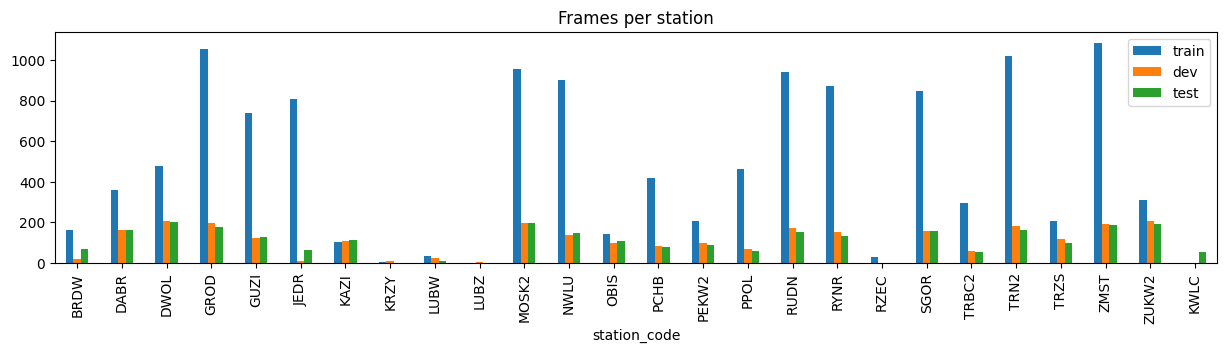

In [5]:
frames_per_station = []
for split in splits: 
    frames_per_station.append(data.get_split(split).metadata.groupby('station_code').count()['index'])
    
frames_per_station = pd.DataFrame(frames_per_station, index=splits).transpose()
frames_per_station.plot(kind='bar', figsize=(15,3), title='Frames per station')


## Calculate MAE per station for train/dev/test set

In [6]:
stations = data.metadata.station_code.unique()

results = []
# highest_dev_mae = 0
# highest_test_mae = 0

for split in splits: 
    split_results = {}
    print(split)
    for station in stations: 
        print(station)
        
        split_results[station] = {}
        gen = train.get_data_generator(split=split, station=station, sampling_rate=sampling_rate, path=data_path, window='fixed')
        data_loader = DataLoader(gen, batch_size=256, shuffle=False, num_workers=0,
                                worker_init_fn=worker_seeding)
    
        test_loss, test_mae = None, None
        try: 
            test_loss, test_mae = train.test_one_epoch(model, data_loader, pick_mae, wandb_log=False)
            test_mae = float(test_mae)
            
        except Exception as e: 
            print(e)
    
        split_results[station]['mae']=test_mae
        split_results[station]['loss']=test_loss
    results.append(split_results)

train
BRDW
train (12444, 17) 100
Test avg loss: 0.029592
Test avg mae: 0.089062

GROD
train (12444, 17) 100
Test avg loss: 0.025606
Test avg mae: 0.057617

GUZI
train (12444, 17) 100
Test avg loss: 0.024516
Test avg mae: 0.040501

JEDR
train (12444, 17) 100
Test avg loss: 0.024908
Test avg mae: 0.044932

MOSK2
train (12444, 17) 100
Test avg loss: 0.024886
Test avg mae: 0.040648

NWLU
train (12444, 17) 100
Test avg loss: 0.024519
Test avg mae: 0.032965

PCHB
train (12444, 17) 100
Test avg loss: 0.024587
Test avg mae: 0.042854

PPOL
train (12444, 17) 100
Test avg loss: 0.026397
Test avg mae: 0.076008

RUDN
train (12444, 17) 100
Test avg loss: 0.025373
Test avg mae: 0.047411

RYNR
train (12444, 17) 100
Test avg loss: 0.025934
Test avg mae: 0.066802

RZEC
train (12444, 17) 100
Test avg loss: 0.023816
Test avg mae: 0.029310

SGOR
train (12444, 17) 100
Test avg loss: 0.024461
Test avg mae: 0.034385

TRBC2
train (12444, 17) 100
Test avg loss: 0.025840
Test avg mae: 0.046694

TRN2
train (12444

#### Plot MAE per station

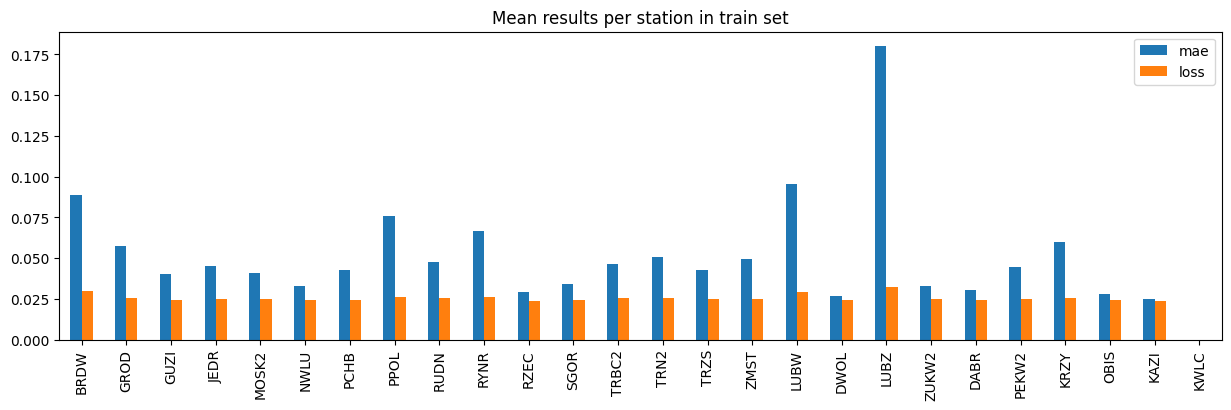

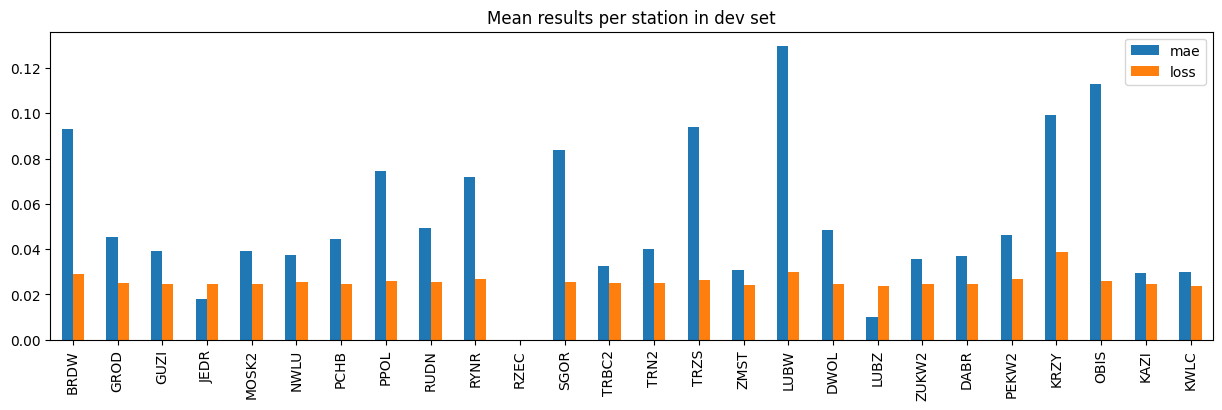

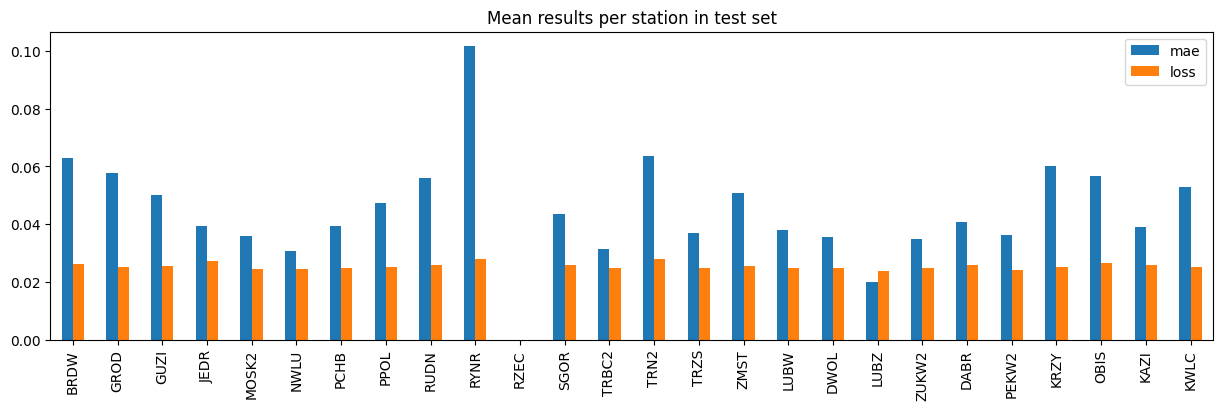

In [7]:
for i, split in enumerate(splits): 
    results_df = pd.DataFrame(results[i]).transpose()

    # for station, values in results_df[['mae']].itertuples():
    #     results_df.loc[station, 'mae'] =  np.mean([v for v in values if v is not None]) 
    # for station, values in results_df[['loss']].itertuples():
    #     results_df.loc[station, 'loss'] =  np.mean([v for v in values if v is not None]) 
        
    results_df.plot(kind='bar', figsize=(15,4), title=f"Mean results per station in {split} set")

    results[i] = results_df

### Check predictions for stations with highest MAE

In [8]:
dev_res = results[1]
station_with_worst_res_dev_set = dev_res[dev_res.mae == dev_res.mae.max()].index[0]
highest_dev_mae = dev_res.loc[station_with_worst_res_dev_set, 'mae']

test_res = results[2]
station_with_worst_res_test_set = test_res[test_res.mae == test_res.mae.max()].index[0]
highest_test_mae = test_res.loc[station_with_worst_res_test_set, 'mae']
print(f"highest mean MAE in dev set: {highest_dev_mae:.2f} for station: {station_with_worst_res_dev_set}")
print(f"highest mean MAE in test set: {highest_test_mae:.2f} for station: {station_with_worst_res_test_set}")





highest mean MAE in dev set: 0.13 for station: LUBW
highest mean MAE in test set: 0.10 for station: RYNR


In [9]:
def plot_sample(sample, model, i, desc=None): 
    fig = plt.figure(figsize=(15, 10))
    
    axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3,  2]})
    axs[0].plot(sample["X"][0].T, label='x')
    plt.legend()
    axs[1].plot(sample["y"][0].T, label='y')
    
    model.eval()  # close the model for evaluation
    
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()
        
        axs[1].plot(pred[0], label='pred', color='orange')
        plt.legend()

        pred_pick_idx  = np.argmax(pred[0])
        true_pick_idx = np.argmax(sample['y'][0])

        
        
        mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds

        fig.suptitle(f"Predictions for sample: {i} {desc}, mae: {mae_error}s")
        
        plt.show()
        
    

### Find random samples that reproduce obtained results 

the model makes at least as bad predictions

In [10]:
##### dev set

dev (2773, 17) 100


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.12958333333333336 LUBW
[1.06 0.4  0.33 0.28 0.23 0.1  0.08 0.07 0.07 0.07 0.07 0.06 0.05 0.05
 0.05 0.04 0.03 0.03 0.01 0.01 0.01 0.01 0.   0.  ]
2 1.06


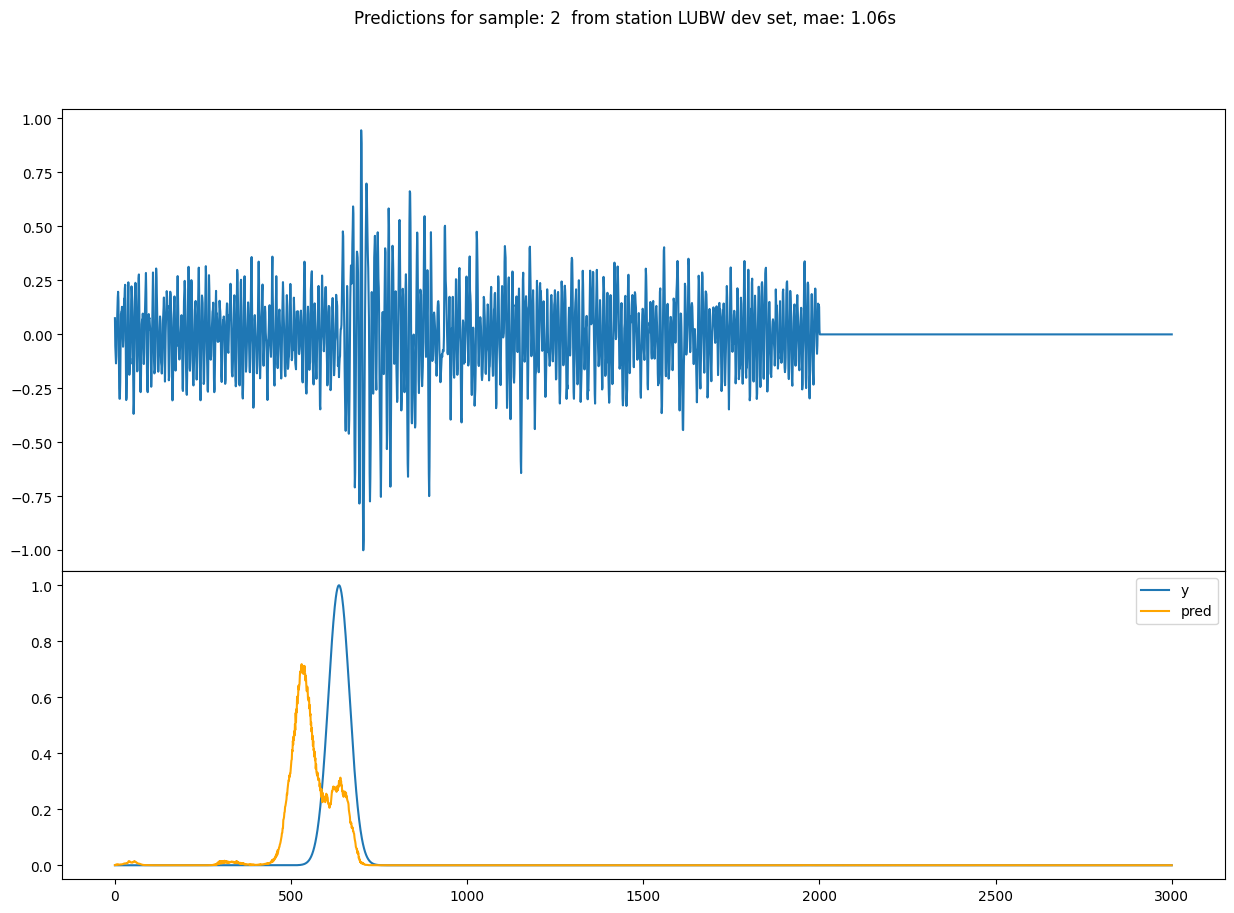

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3 0.4


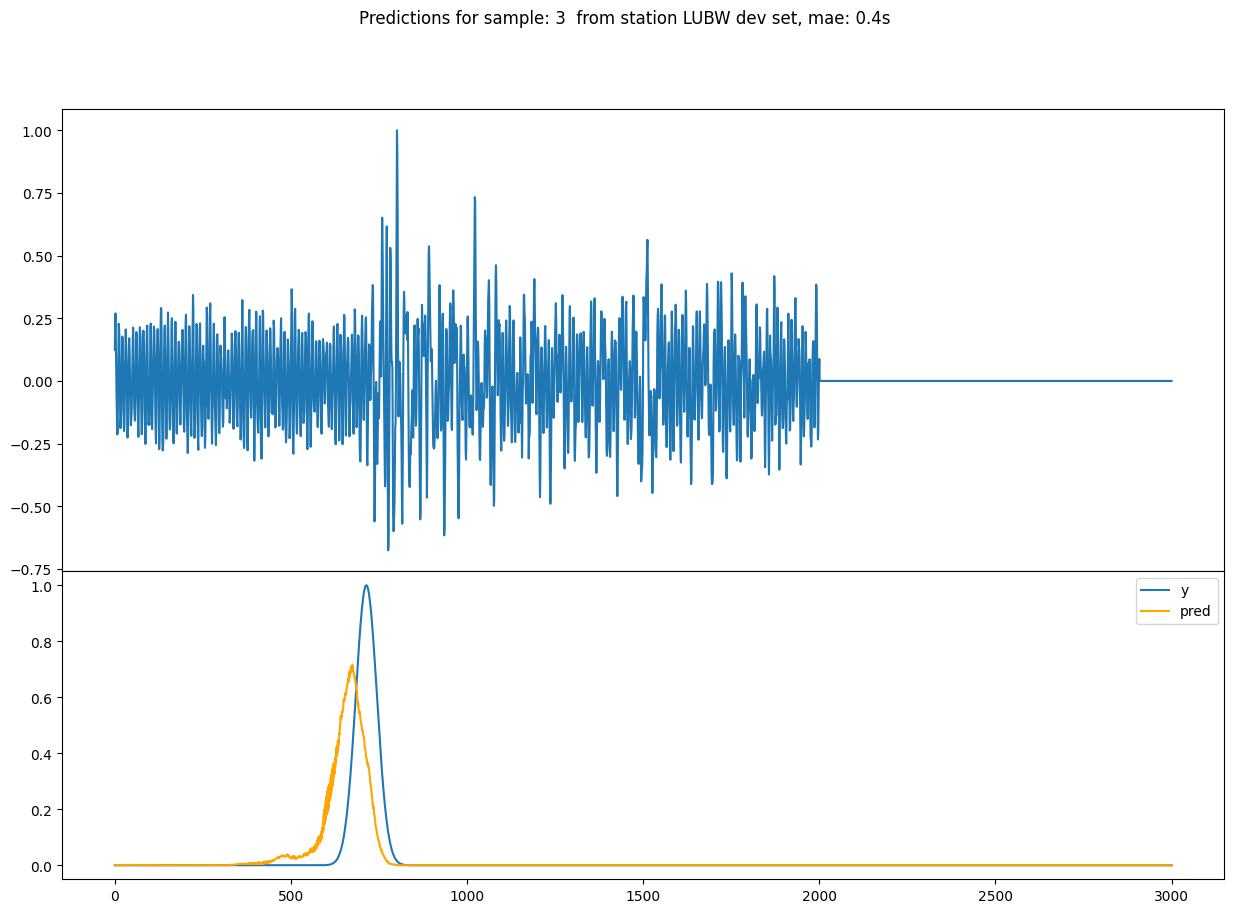

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13 0.33


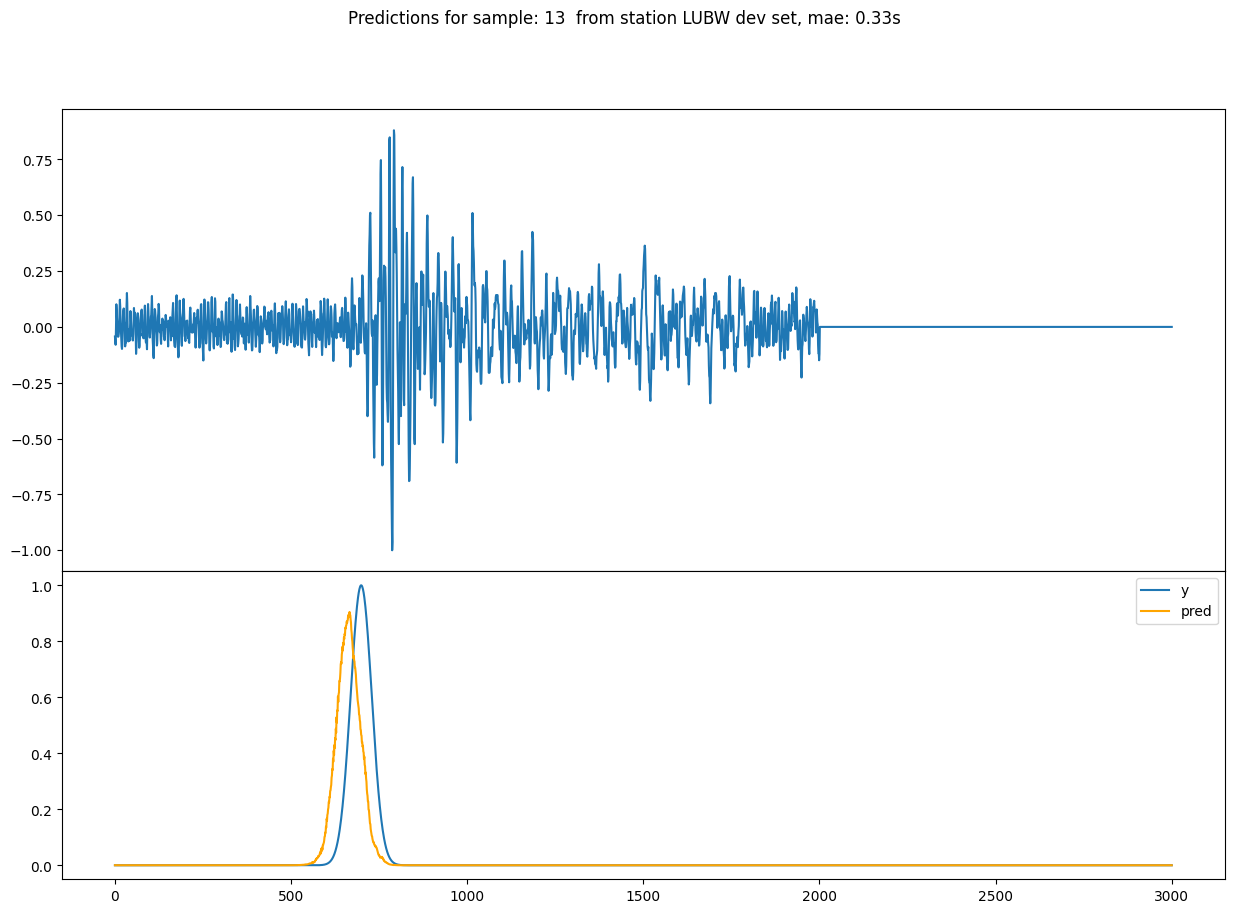

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


22 0.28


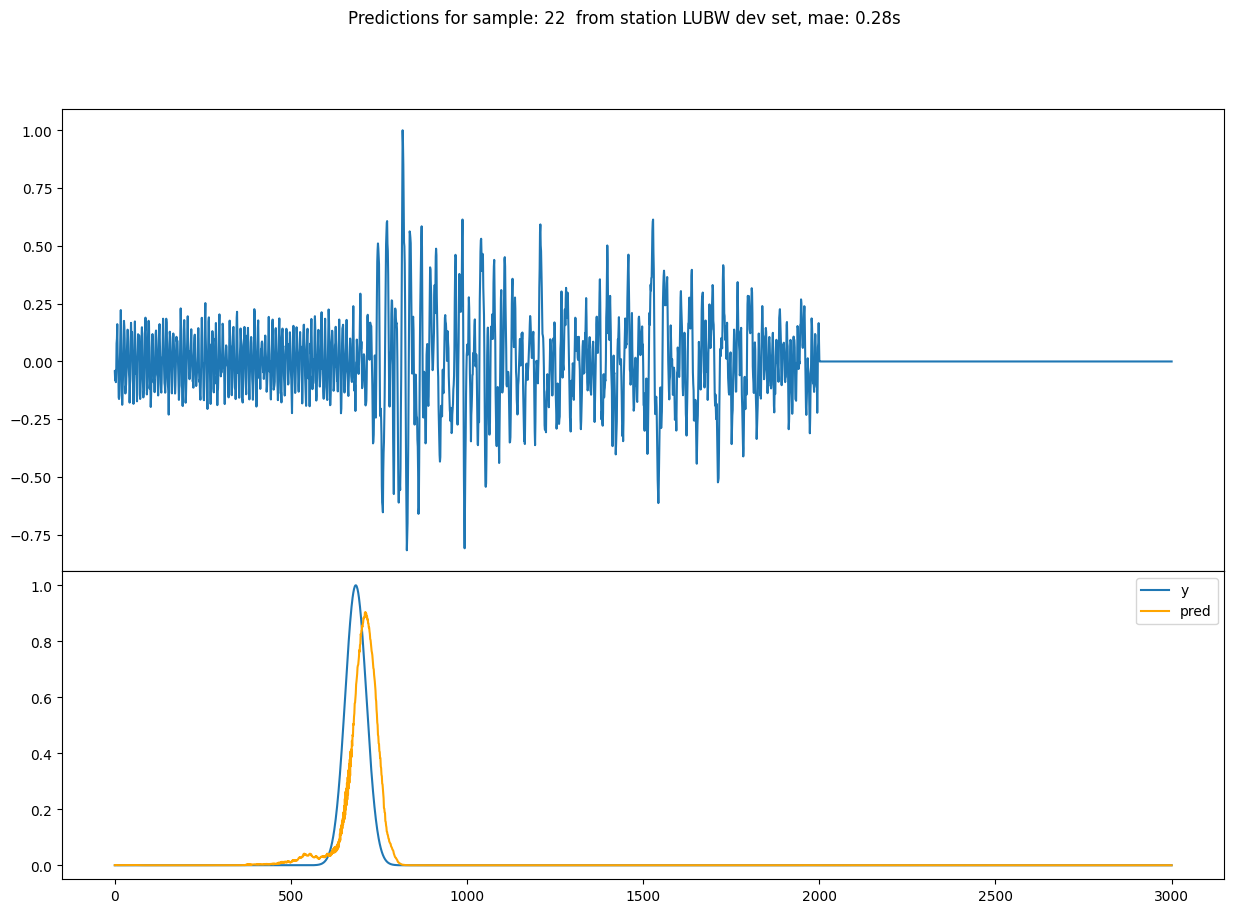

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


17 0.23


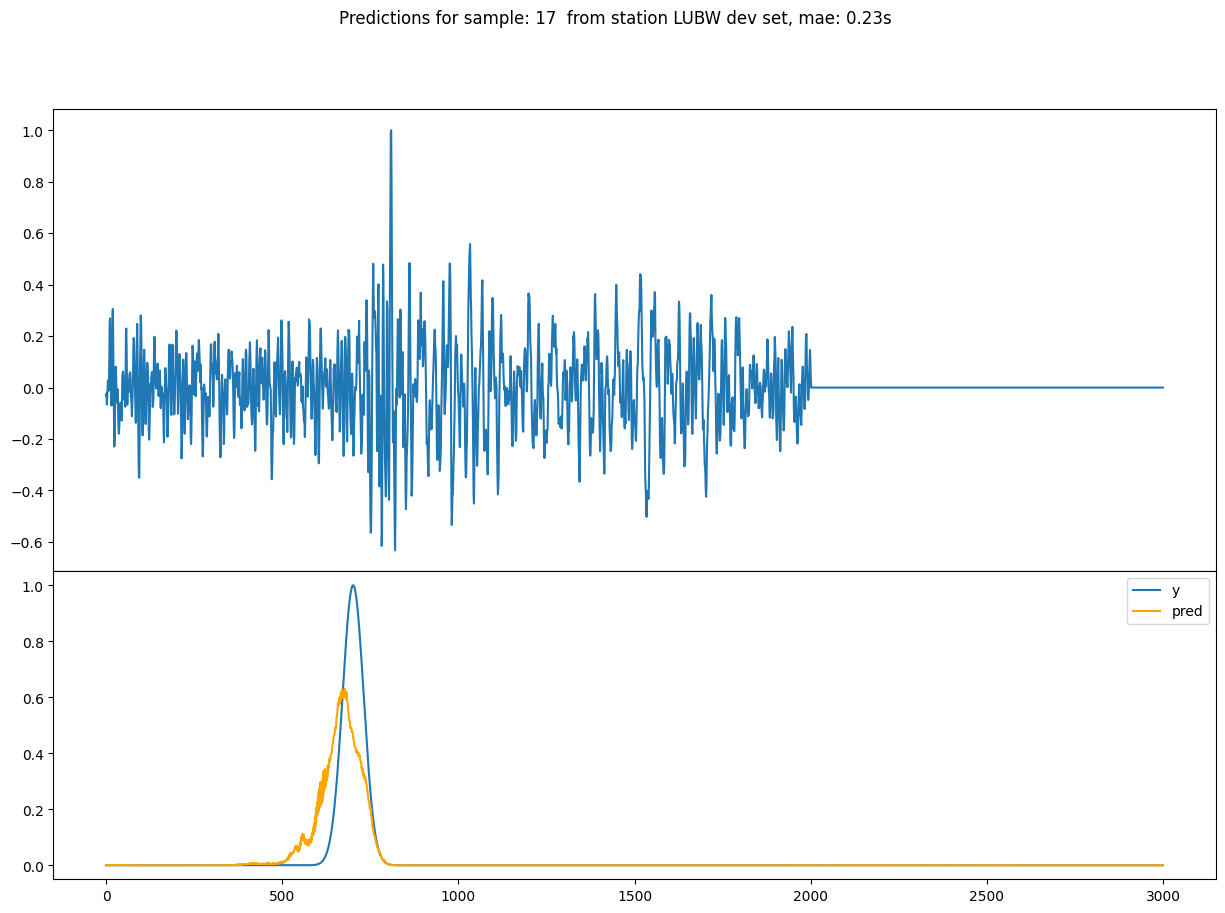

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18 0.1


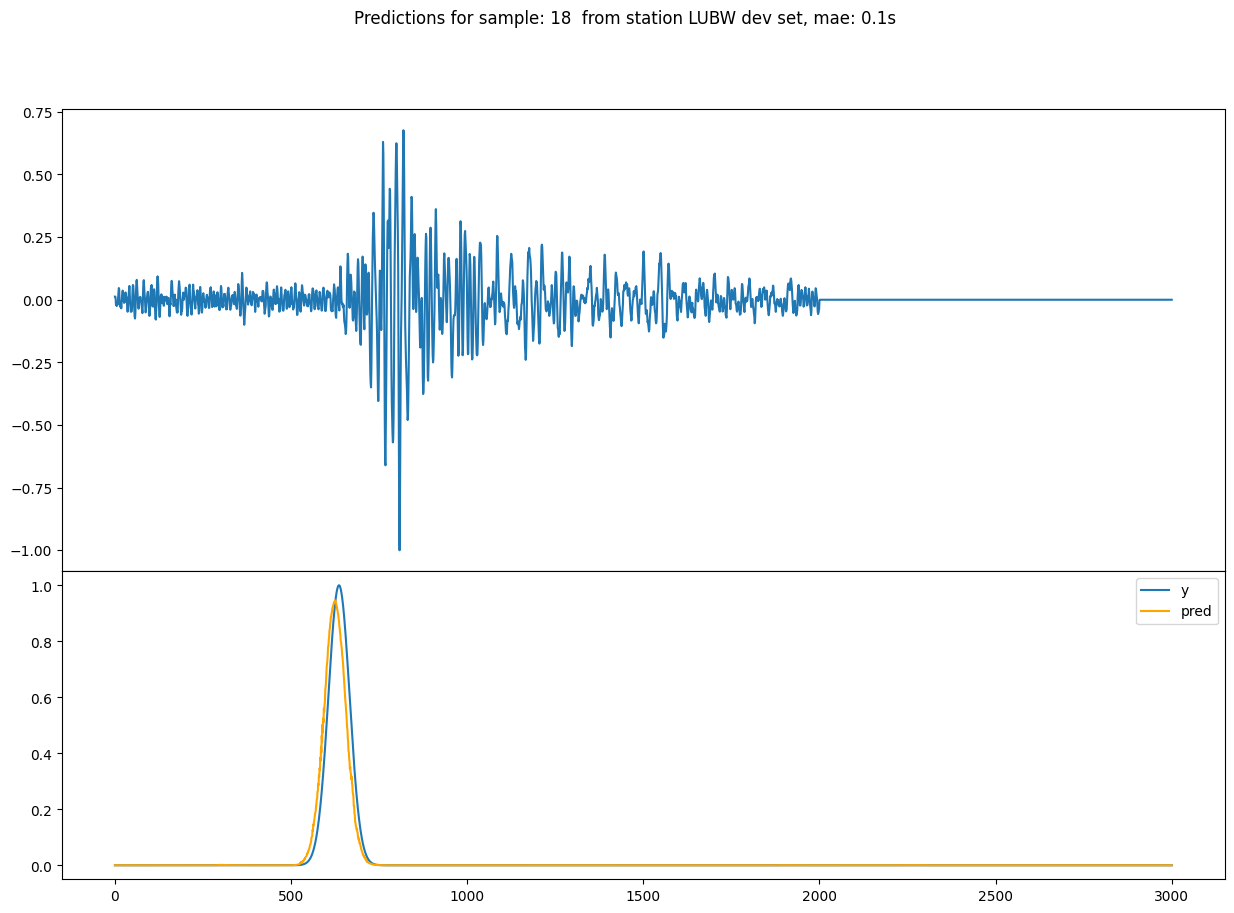

In [11]:

mean_mae = 0
samples = []
split = 'dev'
station = station_with_worst_res_dev_set
window='fixed'

gen = train.get_data_generator(split=split, station=station , sampling_rate=sampling_rate, path=data_path, 
                                window='fixed')


station_mae = []
with torch.no_grad():
    for i in range(len(gen)): 
        # idx = np.random.randint(len(gen))
        idx = i
        sample = gen[idx]
        samples.append(sample)
        pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  
        pred = pred[0].cpu().numpy()

        pred_pick_idx  = np.argmax(pred[0])
        true_pick_idx = np.argmax(sample['y'][0])            
            
        mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds
        station_mae.append(mae_error)

sorted = np.argsort(station_mae)[::-1]
mean_mae = np.mean(station_mae)
print(mean_mae, station_with_worst_res_dev_set)
print(np.array(station_mae)[sorted])


## plot samples with mae error at leas 0.2s
for idx in sorted:
    if station_mae[idx] < 0.1: 
        break
    print(idx, station_mae[idx])
    plot_sample(samples[idx], model, idx, desc=f" from station {station} {split} set")



test (2785, 17) 100
test (2785, 17) 100
test (2785, 17) 100


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.11 2.33 1.23 1.21 0.59 0.53 0.39 0.23 0.22 0.12 0.11 0.11 0.1  0.1
 0.1  0.09 0.09 0.08 0.08 0.08 0.07 0.07 0.07 0.06 0.06 0.06 0.06 0.06
 0.05 0.05 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
91 3.11


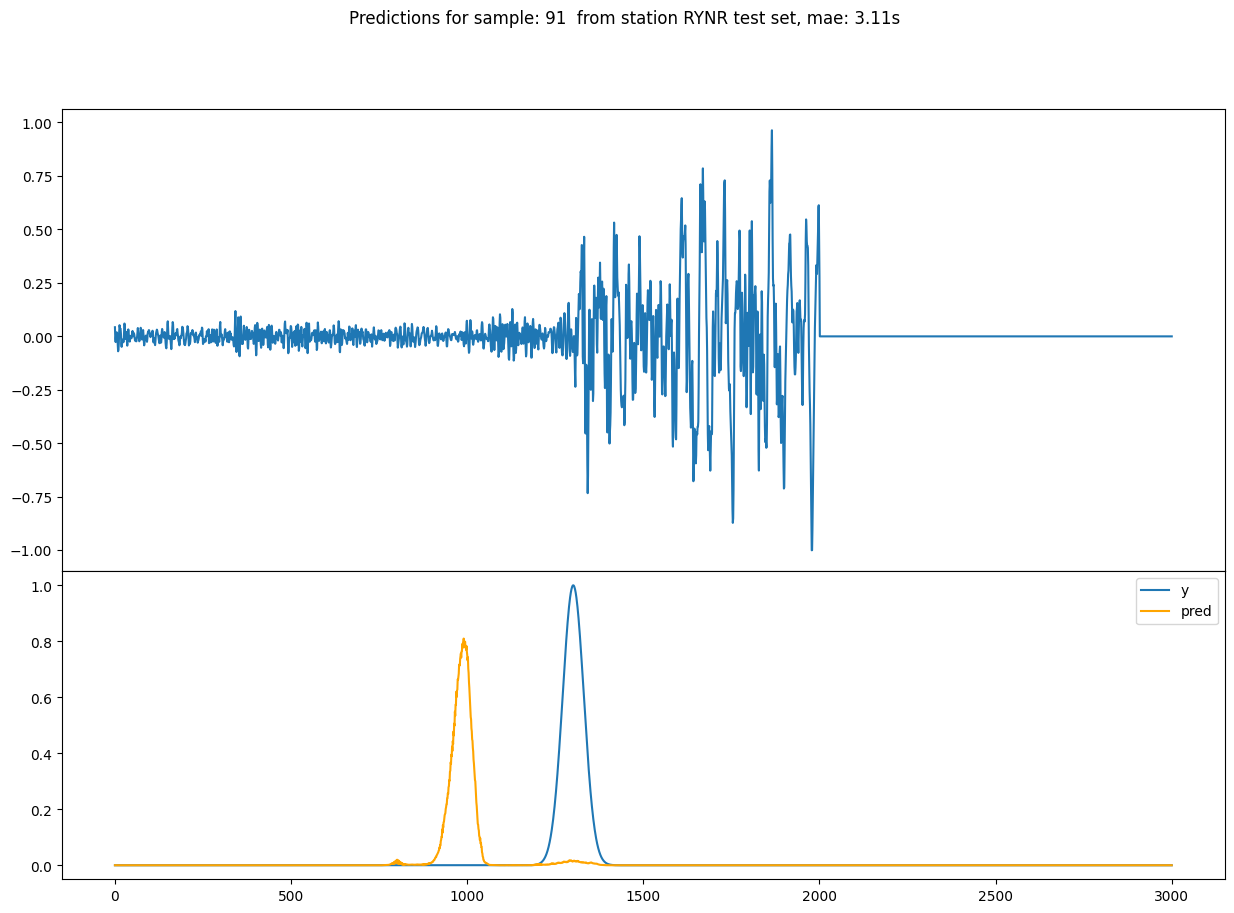

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


46 2.33


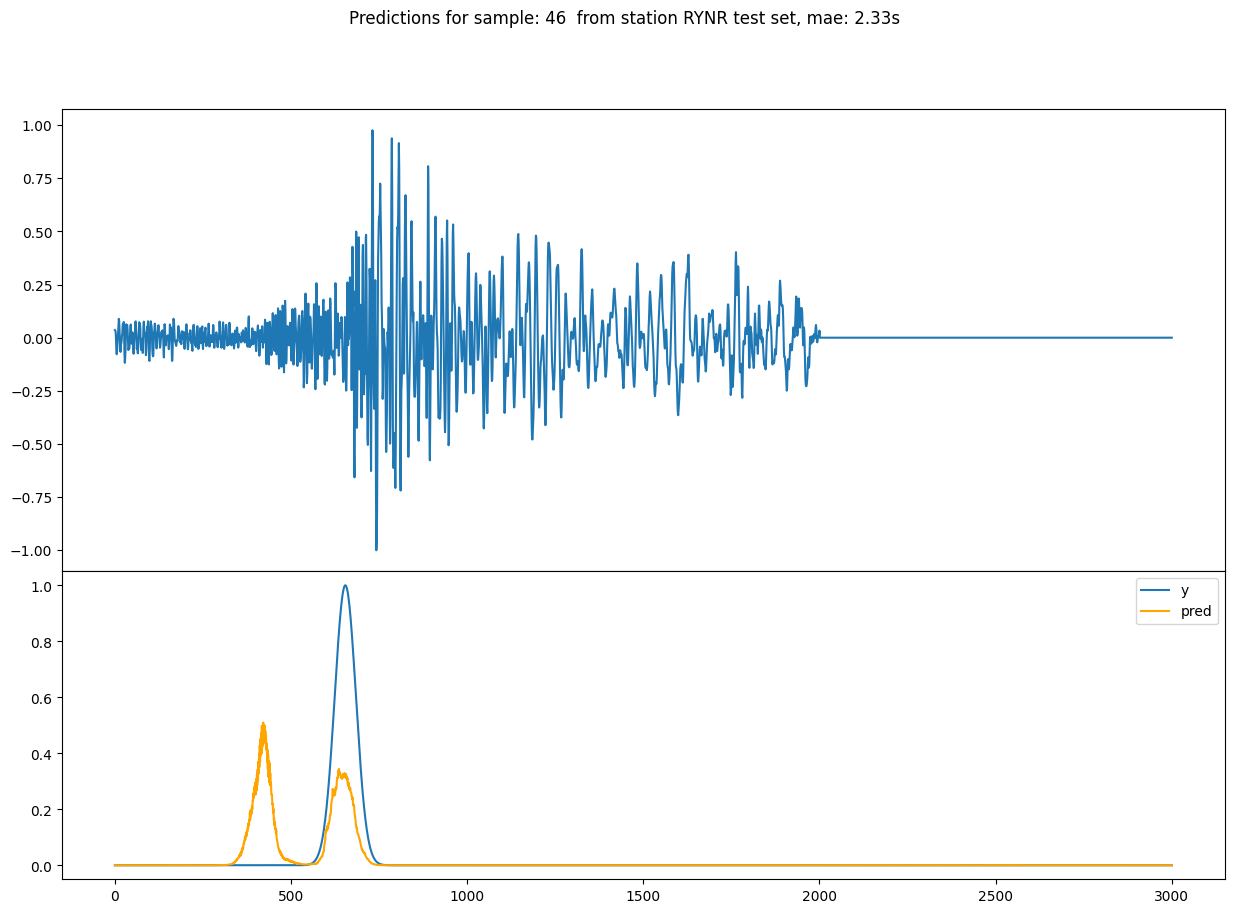

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


63 1.23


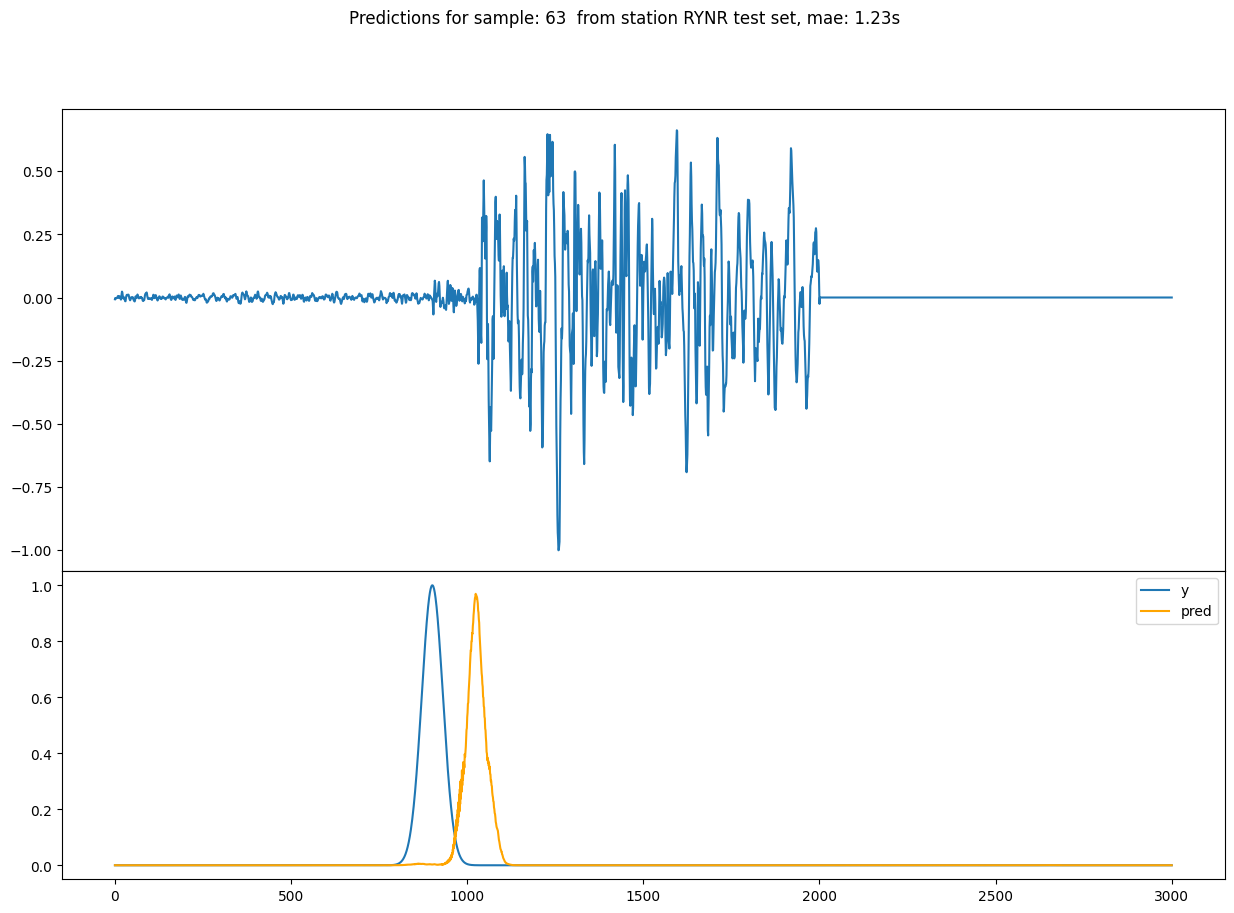

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


40 1.21


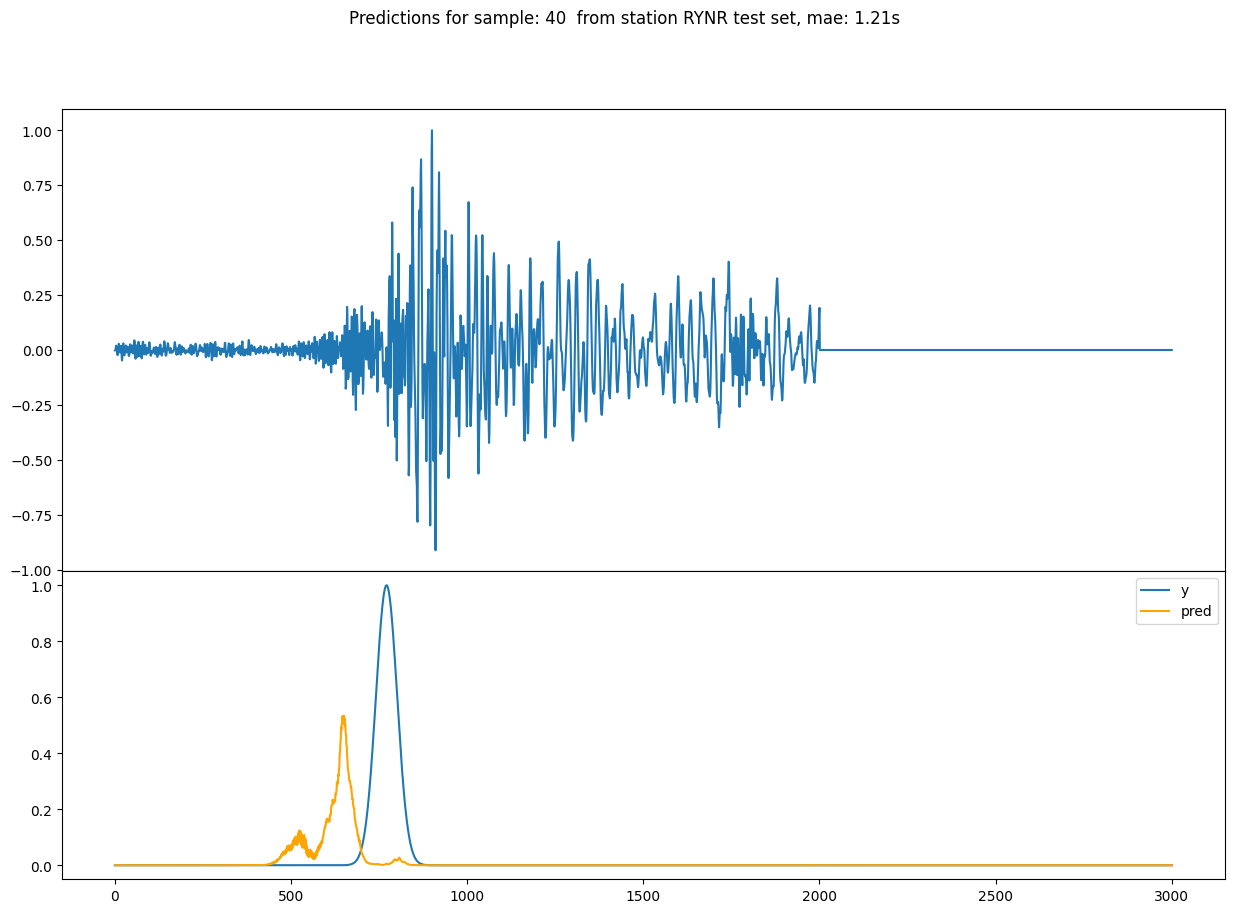

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28 0.59


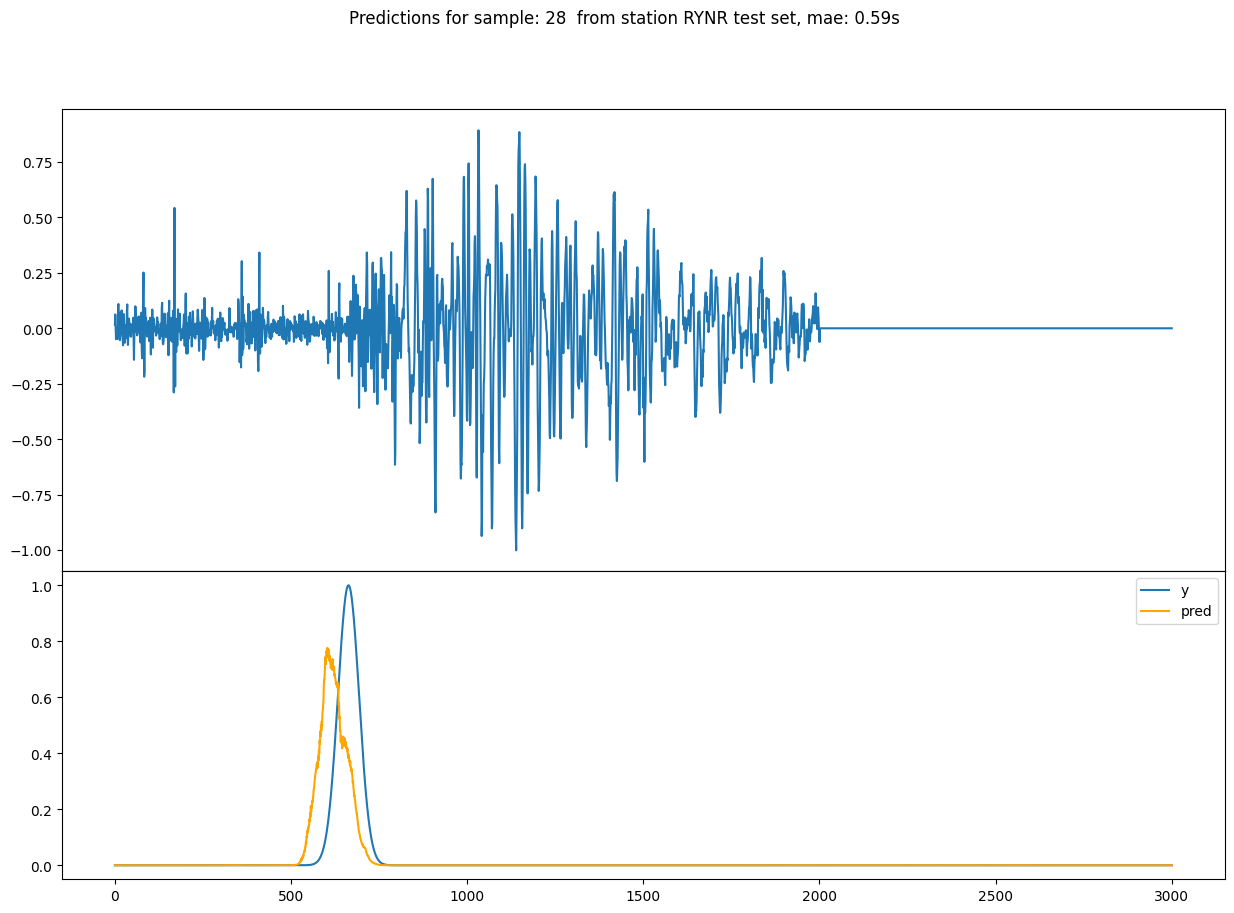

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


106 0.53


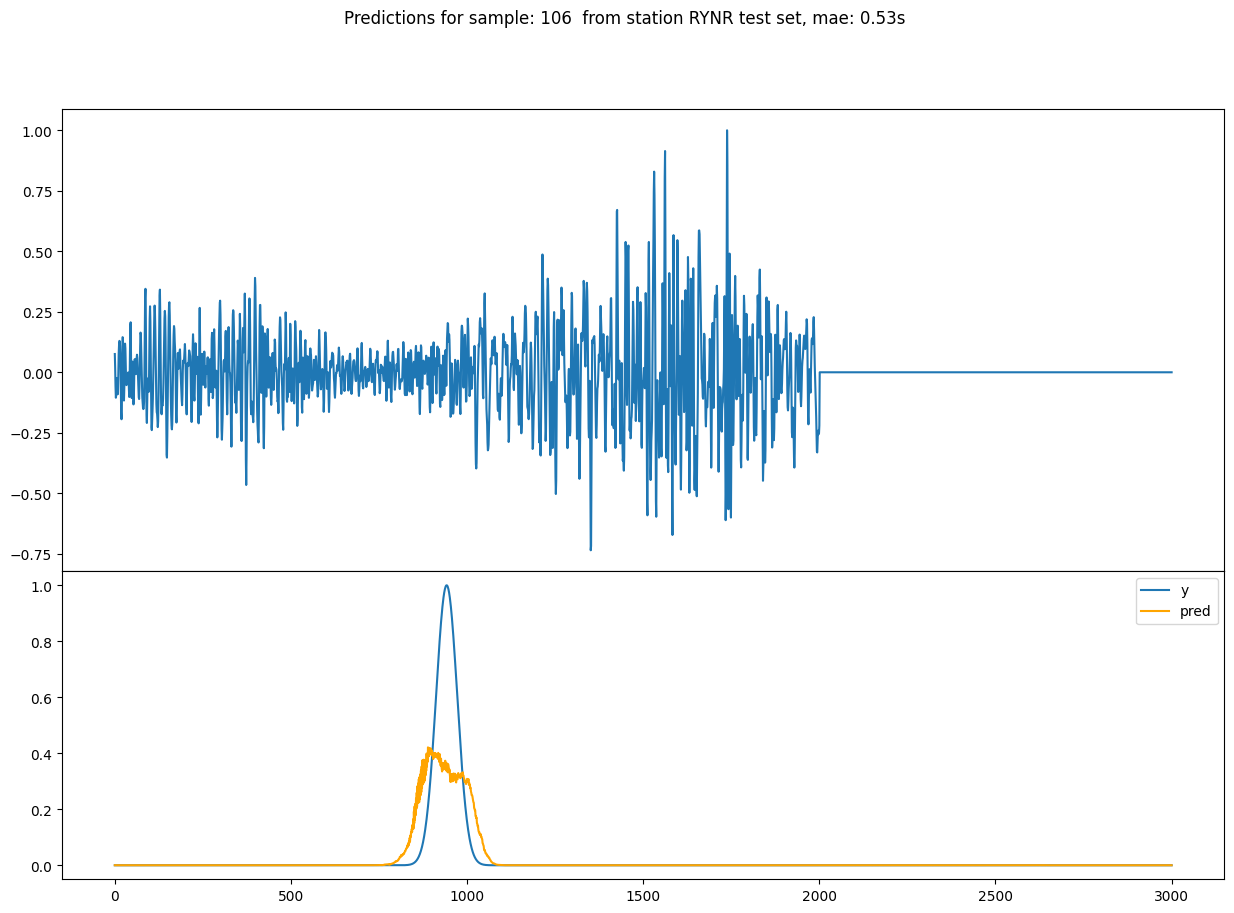

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24 0.39


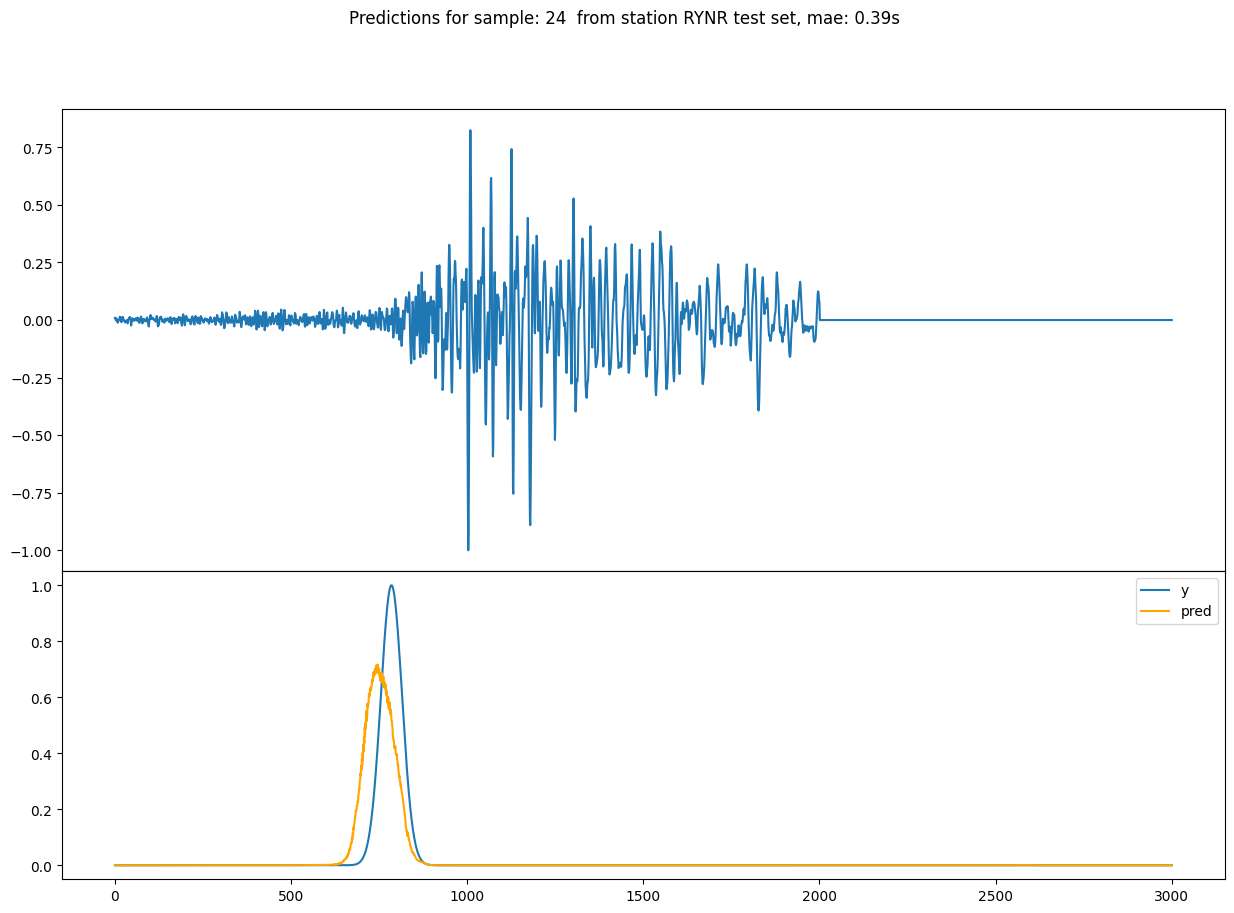

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100 0.23


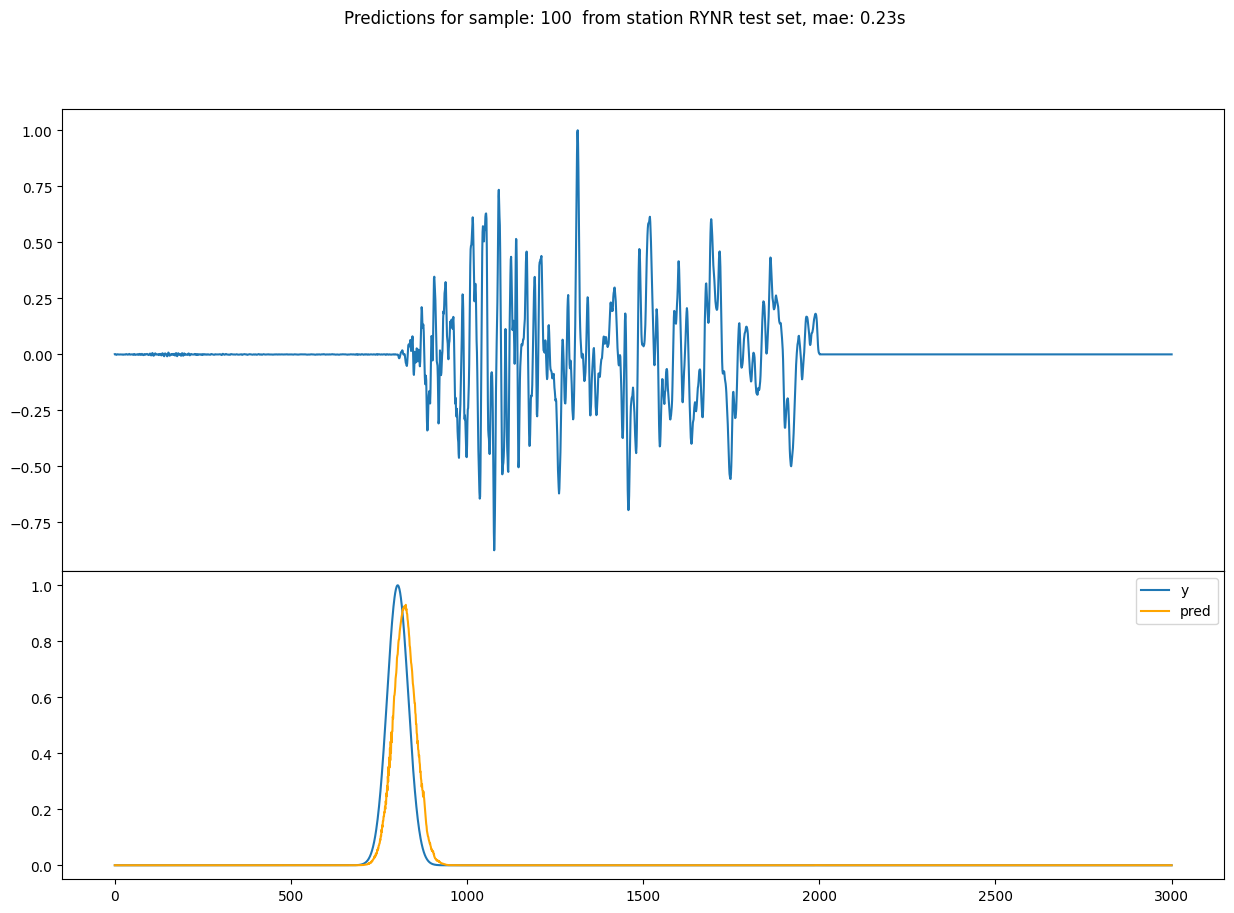

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


119 0.22


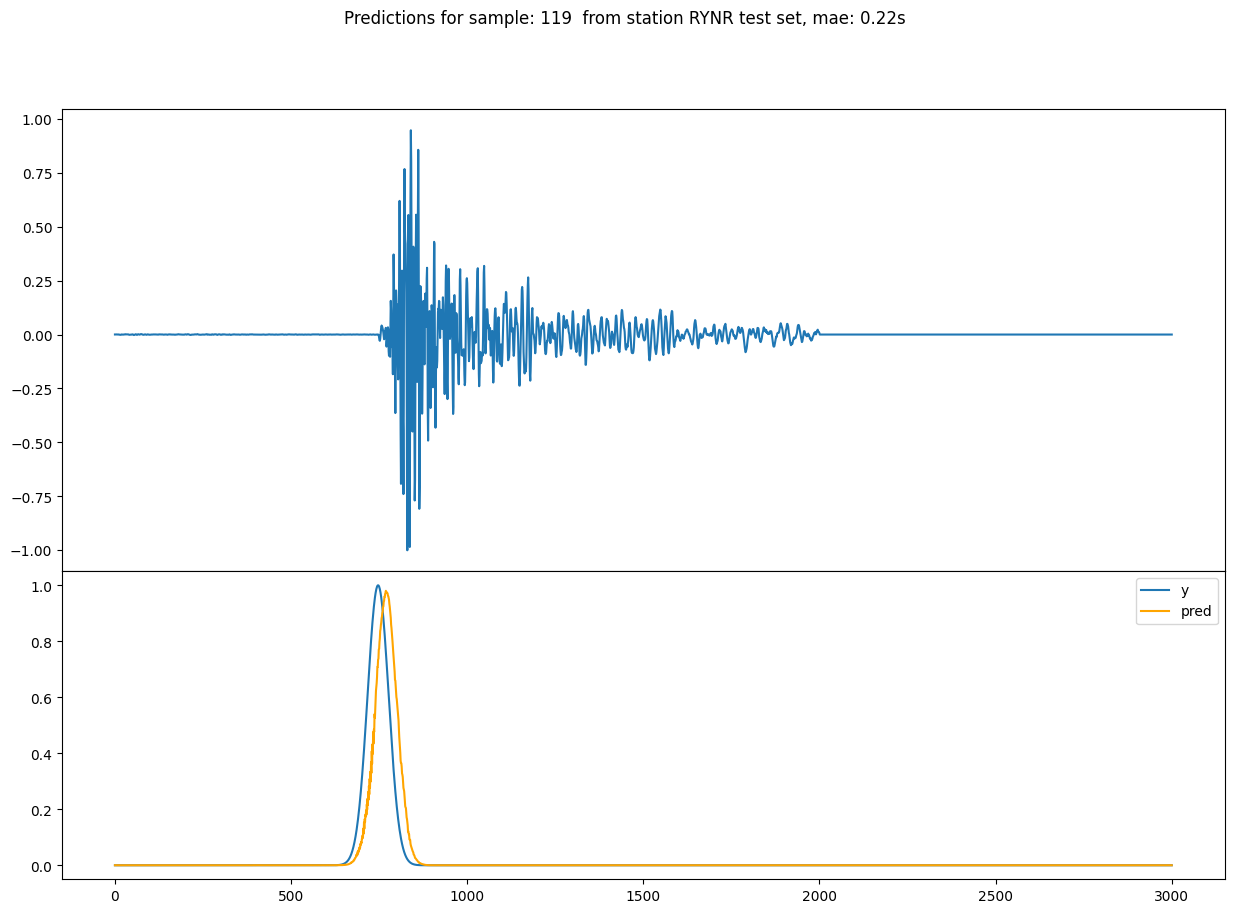

In [12]:

mean_mae = 0
samples = []
split = 'test'
station = station_with_worst_res_test_set

for i in range(3): 
    
    gen = train.get_data_generator(split=split, station=station , sampling_rate=sampling_rate, path=data_path, 
                                  window='fixed')
    station_mae = []
    with torch.no_grad():
        for i in range(len(gen)): 
            # idx = np.random.randint(len(gen))
            idx = i
            sample = gen[idx]
            samples.append(sample)
            pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  
            pred = pred[0].cpu().numpy()
    
            pred_pick_idx  = np.argmax(pred[0])
            true_pick_idx = np.argmax(sample['y'][0])            
                
            mae_error = np.abs(pred_pick_idx - true_pick_idx) /100 #mae in seconds
            station_mae.append(mae_error)
    
    sorted = np.argsort(station_mae)[::-1]
    mean_mae = np.mean(station_mae)

print(np.array(station_mae)[sorted])


## plot samples with mae error at leas 0.2s
for idx in sorted:
    if station_mae[idx] < 0.2: 
        break
    print(idx, station_mae[idx])
    plot_sample(samples[idx], model, idx, desc=f" from station {station} {split} set")

